#  📊 Data Ingestion and Quality Checks
# 
### Purpose: Test data pipeline, explore raw data quality, and validate all data.py functions
### Dependencies: `src/data.py`
### Key Functions Tested:
- `download_multiple_tickers()`
- `load_raw_data()`
- `validate_data_quality()`
- `calculate_returns()`
- `detect_outliers()`
- `handle_missing_data()`

In [1]:
#  Setup and Imports
import os
import sys
# Add project root to Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src.data import (
    download_multiple_tickers,
    load_raw_data,
    validate_data_quality,
    calculate_returns,
    detect_outliers,
    handle_missing_data
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import warnings


warnings.filterwarnings('ignore')
# Configure display
pd.set_option('display.max_columns', None)
plt.style.use('default')  # Using default matplotlib style
sns.set_palette("husl")

print("✅ Imports complete - using existing src/data.py functions")

✅ Imports complete - using existing src/data.py functions


## 1. Data Download and Initial Testing

In [2]:
# Define tickers and date range
tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']
start_date = '2020-01-01'
end_date = '2025-08-31'
data_dir = '../data/raw'

try:
    print(
        f"📥 Downloading {len(tickers)} tickers from {start_date} to {end_date}...")
    results = download_multiple_tickers(
        tickers, start_date, end_date, data_dir)
    print("✅ Download completed!")
    print("📁 Saved files:", results)

    # Verify all downloads successful
    successful_downloads = [r for r in results if r is not None]
    failed_downloads = len(tickers) - len(successful_downloads)

    if failed_downloads > 0:
        print(f"⚠️  {failed_downloads} downloads failed")
    else:
        print("🎉 All downloads successful!")

except Exception as e:
    print(f"❌ Download error: {e}")
    print("📝 Note: Continuing with any existing data files...")

📥 Downloading 5 tickers from 2020-01-01 to 2025-08-31...


Column 'Adj Close' not found for AAPL
Using 'Close' instead of 'Adj Close' for AAPL
Column 'Adj Close' not found for GOOGL
Using 'Close' instead of 'Adj Close' for GOOGL
Column 'Adj Close' not found for MSFT
Using 'Close' instead of 'Adj Close' for MSFT
Column 'Adj Close' not found for TSLA
Using 'Close' instead of 'Adj Close' for TSLA
Column 'Adj Close' not found for AMZN
Using 'Close' instead of 'Adj Close' for AMZN


✅ Download completed!
📁 Saved files: ['../data/raw/AAPL.csv', '../data/raw/GOOGL.csv', '../data/raw/MSFT.csv', '../data/raw/TSLA.csv', '../data/raw/AMZN.csv']
🎉 All downloads successful!


## 2. Data Loading and Basic Inspection

In [3]:
# Load AAPL data for detailed analysis
try:
    aapl_data = load_raw_data('../data/raw/AAPL.csv')
    print(f"📊 AAPL data loaded successfully")
    print(f"   Shape: {aapl_data.shape}")
    print(f"   Date range: {aapl_data.index.min()} to {aapl_data.index.max()}")
    print(f"   Columns: {list(aapl_data.columns)}")
    print(
        f"   Memory usage: {aapl_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

except FileNotFoundError:
    print("❌ AAPL.csv not found. Please run data download first.")
except Exception as e:
    print(f"❌ Error loading AAPL data: {e}")

# Display first and last few rows
print("📋 First 5 rows:")
display(aapl_data.head())

print("\n📋 Last 5 rows:")
display(aapl_data.tail())

print("\n📊 Basic Statistics:")
display(aapl_data.describe())

📊 AAPL data loaded successfully
   Shape: (1423, 6)
   Date range: 2020-01-02 00:00:00 to 2025-08-29 00:00:00
   Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
   Memory usage: 0.08 MB
📋 First 5 rows:


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,71.545882,72.598884,71.292296,72.538506,135480400,72.538506
2020-01-03,71.765659,72.594048,71.608677,71.833282,146322800,71.833282
2020-01-06,70.954195,72.444328,70.703020,72.405685,118387200,72.405685
2020-01-07,72.415337,72.671341,71.845369,72.065147,108872000,72.065147
2020-01-08,71.768079,73.526295,71.768079,73.224403,132079200,73.224403



📋 Last 5 rows:


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2025-08-25,226.479996,229.300003,226.229996,227.160004,30983100,227.160004
2025-08-26,226.869995,229.490005,224.690002,229.309998,54575100,229.309998
2025-08-27,228.610001,230.899994,228.259995,230.490005,31259500,230.490005
2025-08-28,230.820007,233.410004,229.339996,232.559998,38074700,232.559998
2025-08-29,232.509995,233.380005,231.369995,232.139999,39418400,232.139999



📊 Basic Statistics:


,Open,High,Low,Close,Volume,Adj Close
count,1423.000000,1423.000000,1423.000000,1423.000000,1.423000e+03,1423.000000
mean,159.145185,160.955737,157.484669,159.304504,8.666024e+07,159.304504
std,44.840633,45.148733,44.560991,44.888032,5.184110e+07,44.888032
min,55.215083,55.316759,51.470005,54.316940,2.323470e+07,54.316940
25%,130.305757,131.583258,128.636367,130.266479,5.246465e+07,130.266479
50%,159.266444,161.462124,156.828725,159.754059,7.243410e+07,159.754059
75%,189.352735,190.959476,188.113272,189.698601,1.030379e+08,189.698601
max,257.276679,259.179926,256.718662,258.103729,4.265100e+08,258.103729


## 3. Comprehensive Data Quality Validation

In [4]:
# Test data quality validation function
print("🔍 Running comprehensive data quality checks...\n")

try:
    # Basic validation
    basic_quality = validate_data_quality(aapl_data, detailed=False)
    print(f"Basic Quality Check: {'✅ PASS' if basic_quality else '❌ FAIL'}")

    # Detailed validation
    detailed_quality = validate_data_quality(aapl_data, detailed=True)
    print("\n📋 Detailed Data Quality Report:")
    print(
        f"   Overall Quality: {'✅ PASS' if detailed_quality['overall'] else '❌ ISSUES FOUND'}")

    if detailed_quality['issues']:
        print("   🚨 Issues detected:")
        for issue in detailed_quality['issues']:
            print(f"     - {issue}")
    else:
        print("   🎉 No data quality issues found!")

    # Display quality metrics if available
    if 'metrics' in detailed_quality:
        print("\n📊 Quality Metrics:")
        for metric, value in detailed_quality['metrics'].items():
            print(f"   {metric}: {value}")

except Exception as e:
    print(f"❌ Error in data quality validation: {e}")

🔍 Running comprehensive data quality checks...

Basic Quality Check: ✅ PASS

📋 Detailed Data Quality Report:
   Overall Quality: ✅ PASS
   🎉 No data quality issues found!


## 4. Outlier Detection Testing

In [5]:
# Test outlier detection on different columns and methods
print("🔍 Testing outlier detection functions...\n")

# Test on Close prices
try:
    close_outliers_iqr = detect_outliers(aapl_data['Close'], method='iqr')
    close_outliers_zscore = detect_outliers(
        aapl_data['Close'], method='zscore', threshold=3.0)

    print(f"📊 Close Price Outlier Analysis:")
    print(
        f"   IQR method: {close_outliers_iqr.sum()} outliers ({close_outliers_iqr.sum()/len(aapl_data)*100:.2f}%)")
    print(
        f"   Z-score method: {close_outliers_zscore.sum()} outliers ({close_outliers_zscore.sum()/len(aapl_data)*100:.2f}%)")

    # Test on Volume (typically has more outliers)
    volume_outliers = detect_outliers(aapl_data['Volume'], method='iqr')
    print(f"\n📊 Volume Outlier Analysis:")
    print(
        f"   IQR method: {volume_outliers.sum()} outliers ({volume_outliers.sum()/len(aapl_data)*100:.2f}%)")

    # Show some outlier examples
    if close_outliers_iqr.sum() > 0:
        outlier_dates = aapl_data.index[close_outliers_iqr].tolist()[
            :5]  # Show first 5
        print(f"\n📅 Example outlier dates (Close prices): {outlier_dates}")

except Exception as e:
    print(f"❌ Error in outlier detection: {e}")

🔍 Testing outlier detection functions...

📊 Close Price Outlier Analysis:
   IQR method: 0 outliers (0.00%)
   Z-score method: 0 outliers (0.00%)

📊 Volume Outlier Analysis:
   IQR method: 79 outliers (5.55%)


## 5. Missing Data Handling Testing

In [6]:
# Test missing data handling (simulate missing data first)
print("🔍 Testing missing data handling...\n")

try:
    # Create a copy with simulated missing data
    test_data = aapl_data.copy()

    # Simulate missing data
    np.random.seed(42)
    missing_indices = np.random.choice(test_data.index, size=10, replace=False)
    test_data.loc[missing_indices, 'Close'] = np.nan
    test_data.loc[missing_indices[:5], 'Volume'] = np.nan

    print(f"📊 Simulated missing data:")
    print(f"   Total missing Close values: {test_data['Close'].isna().sum()}")
    print(
        f"   Total missing Volume values: {test_data['Volume'].isna().sum()}")

    # Test different missing data handling methods
    methods_to_test = ['forward_fill', 'backward_fill', 'interpolate', 'drop']

    for method in methods_to_test:
        try:
            cleaned_data = handle_missing_data(test_data, method=method)
            remaining_missing = cleaned_data.isna().sum().sum()
            print(f"   {method}: {remaining_missing} missing values remaining")

        except Exception as method_error:
            print(f"   {method}: ❌ Error - {method_error}")

except Exception as e:
    print(f"❌ Error in missing data testing: {e}")

🔍 Testing missing data handling...

📊 Simulated missing data:
   Total missing Close values: 10
   Total missing Volume values: 5
   forward_fill: 0 missing values remaining
   backward_fill: 0 missing values remaining
   interpolate: 0 missing values remaining
   drop: 0 missing values remaining


## 6. Returns Calculation Testing

In [7]:
# Test returns calculation function
print("📈 Testing returns calculation...\n")

try:
    # Test different return calculation methods
    simple_returns = calculate_returns(aapl_data['Close'], method='simple')
    log_returns = calculate_returns(aapl_data['Close'], method='log')

    print(f"📊 Returns Analysis:")
    print(
        f"   Simple returns - Mean: {simple_returns.mean():.4f}, Std: {simple_returns.std():.4f}")
    print(
        f"   Log returns - Mean: {log_returns.mean():.4f}, Std: {log_returns.std():.4f}")
    print(
        f"   Non-null values: Simple={simple_returns.count()}, Log={log_returns.count()}")

    # Check for extreme returns
    extreme_positive = (simple_returns > 0.1).sum()  # >10% daily return
    extreme_negative = (simple_returns < -0.1).sum()  # <-10% daily return
    print(
        f"   Extreme returns: +10%: {extreme_positive}, -10%: {extreme_negative}")

except Exception as e:
    print(f"❌ Error in returns calculation: {e}")

📈 Testing returns calculation...

📊 Returns Analysis:
   Simple returns - Mean: 0.0010, Std: 0.0204
   Log returns - Mean: 0.0008, Std: 0.0203
   Non-null values: Simple=1422, Log=1422
   Extreme returns: +10%: 4, -10%: 1


## 7. Data Visualization

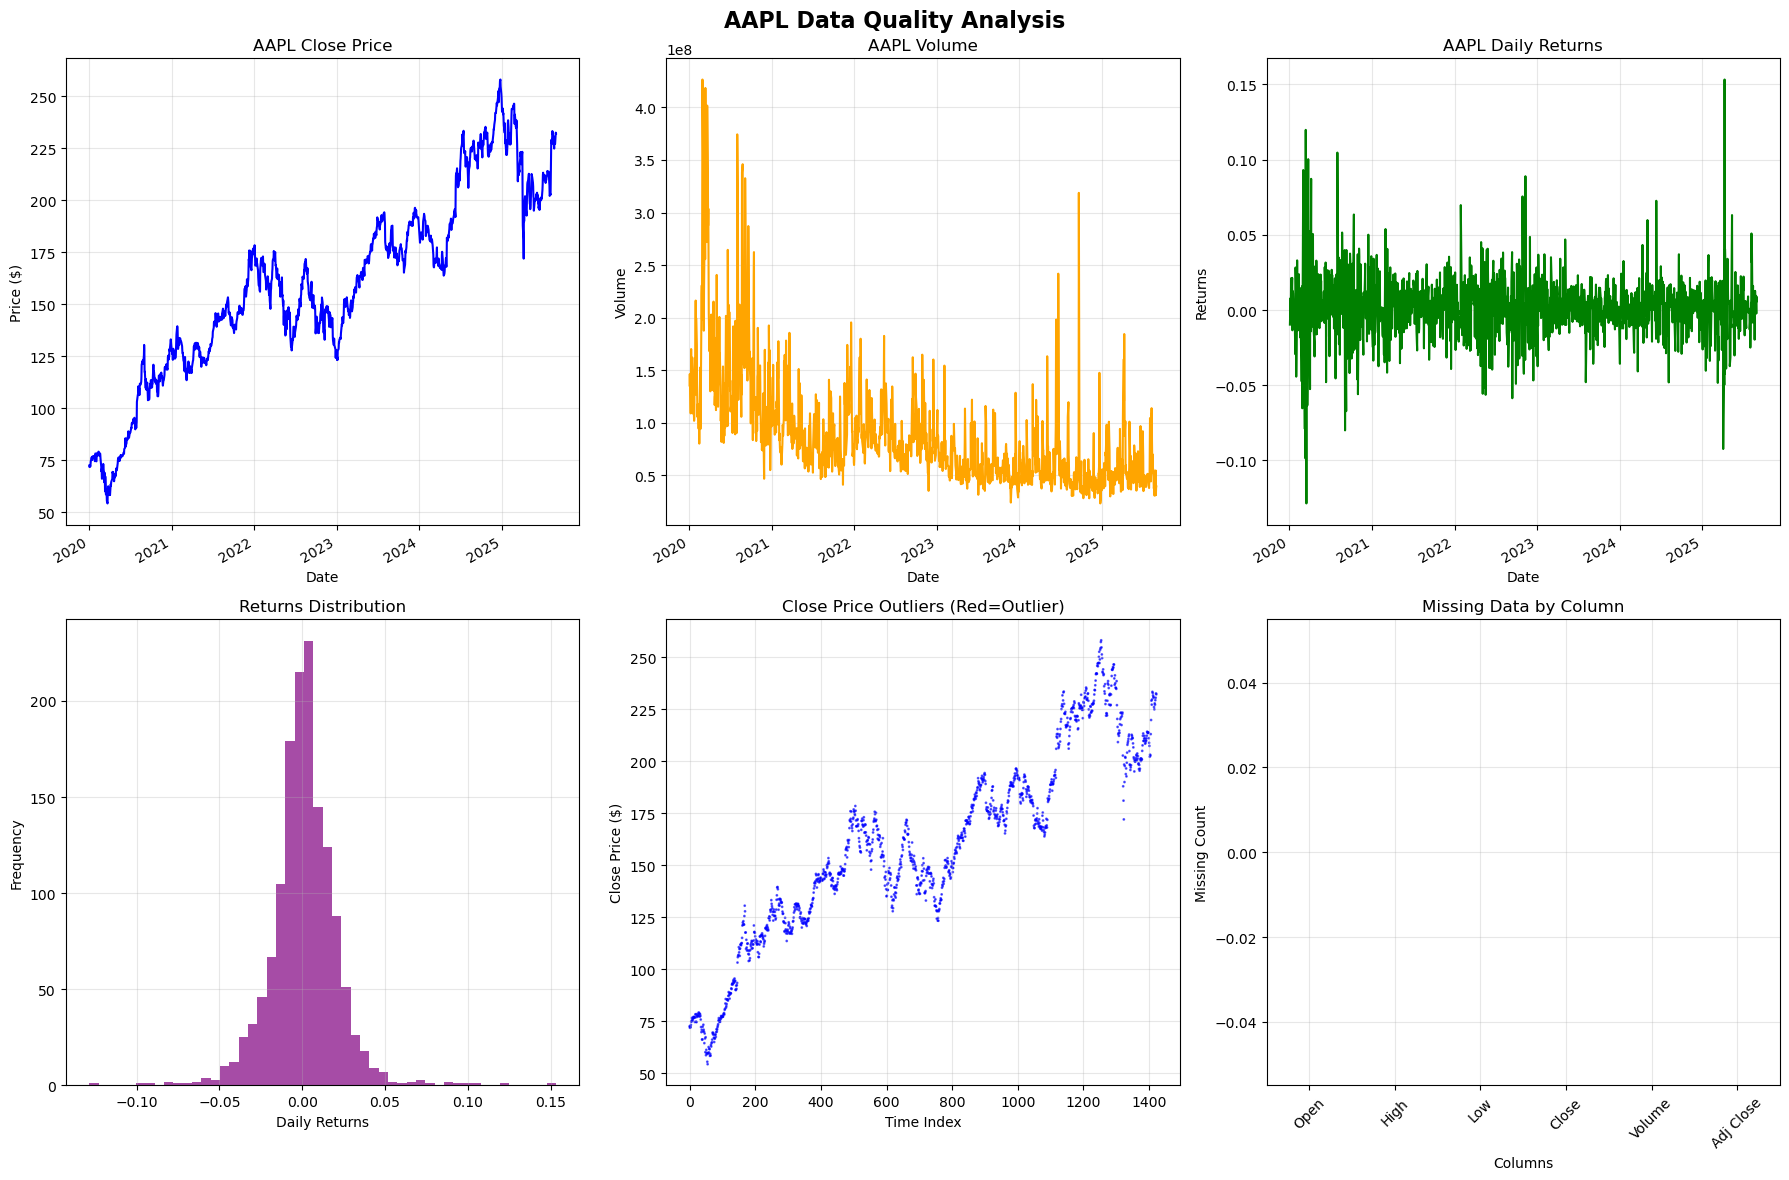

In [8]:
# Create comprehensive visualization
try:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('AAPL Data Quality Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Close Price
    aapl_data['Close'].plot(title='AAPL Close Price',
                            ax=axes[0, 0], color='blue')
    axes[0, 0].set_ylabel('Price ($)')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Volume
    aapl_data['Volume'].plot(
        title='AAPL Volume', ax=axes[0, 1], color='orange')
    axes[0, 1].set_ylabel('Volume')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Daily Returns
    returns = calculate_returns(aapl_data['Close'])
    returns.plot(title='AAPL Daily Returns', ax=axes[0, 2], color='green')
    axes[0, 2].set_ylabel('Returns')
    axes[0, 2].grid(True, alpha=0.3)

    # Plot 4: Returns Distribution
    returns.dropna().hist(bins=50, ax=axes[1, 0], alpha=0.7, color='purple')
    axes[1, 0].set_title('Returns Distribution')
    axes[1, 0].set_xlabel('Daily Returns')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: Outliers visualization
    close_outliers = detect_outliers(aapl_data['Close'], method='iqr')
    axes[1, 1].scatter(range(len(aapl_data)), aapl_data['Close'],
                       c=['red' if x else 'blue' for x in close_outliers],
                       alpha=0.6, s=1)
    axes[1, 1].set_title('Close Price Outliers (Red=Outlier)')
    axes[1, 1].set_xlabel('Time Index')
    axes[1, 1].set_ylabel('Close Price ($)')
    axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Missing data pattern (if any)
    missing_pattern = aapl_data.isna().sum()
    missing_pattern.plot(kind='bar', ax=axes[1, 2], color='coral')
    axes[1, 2].set_title('Missing Data by Column')
    axes[1, 2].set_xlabel('Columns')
    axes[1, 2].set_ylabel('Missing Count')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Error in visualization: {e}")

## 8. Multi-Stock Comparison

📊 Loading all stock data for comparison...

✅ AAPL: 1423 records
✅ GOOGL: 1423 records
✅ MSFT: 1423 records
✅ TSLA: 1423 records
✅ AMZN: 1423 records

📈 Successfully loaded 5/5 stocks


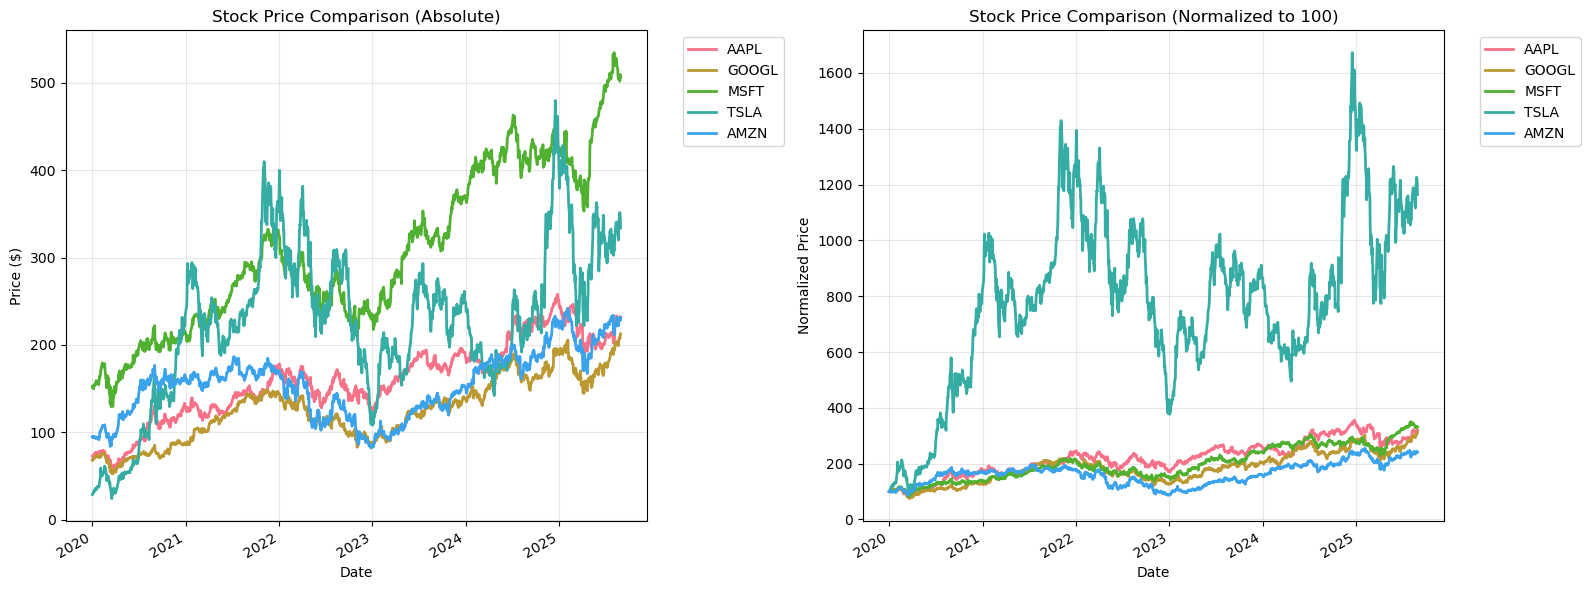


📊 Stock Returns Correlation Matrix:


,AAPL,GOOGL,MSFT,TSLA,AMZN
AAPL,1.000,0.634,0.722,0.497,0.600
GOOGL,0.634,1.000,0.726,0.422,0.649
MSFT,0.722,0.726,1.000,0.452,0.678
TSLA,0.497,0.422,0.452,1.000,0.450
AMZN,0.600,0.649,0.678,0.450,1.000


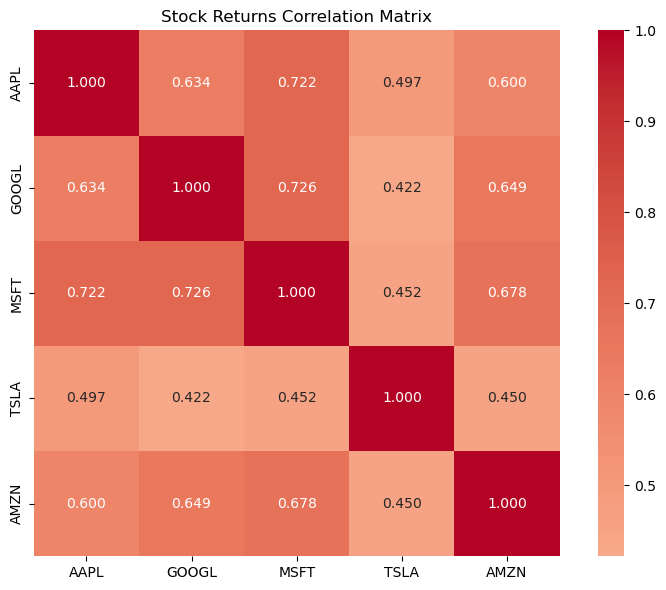

In [9]:
# Load and compare all downloaded stocks
print("📊 Loading all stock data for comparison...\n")

all_data = {}
successful_loads = 0

for ticker in tickers:
    try:
        data = load_raw_data(f'../data/raw/{ticker}.csv')
        all_data[ticker] = data['Close']
        successful_loads += 1
        print(f"✅ {ticker}: {data.shape[0]} records")
    except Exception as e:
        print(f"❌ {ticker}: Failed to load - {e}")

print(f"\n📈 Successfully loaded {successful_loads}/{len(tickers)} stocks")

if successful_loads > 1:
    try:
        # Create comparison DataFrame
        comparison_df = pd.DataFrame(all_data)

        # Normalize prices for comparison (base = 100)
        normalized_df = comparison_df.div(comparison_df.iloc[0]) * 100

        # Create comparison plots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Raw prices
        comparison_df.plot(title='Stock Price Comparison (Absolute)',
                           ax=axes[0], linewidth=2)
        axes[0].set_ylabel('Price ($)')
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0].grid(True, alpha=0.3)

        # Normalized prices
        normalized_df.plot(title='Stock Price Comparison (Normalized to 100)',
                           ax=axes[1], linewidth=2)
        axes[1].set_ylabel('Normalized Price')
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Calculate correlation matrix
        returns_df = comparison_df.pct_change().dropna()
        correlation_matrix = returns_df.corr()

        print("\n📊 Stock Returns Correlation Matrix:")
        display(correlation_matrix.round(3))

        # Visualize correlation
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
                    center=0, square=True, fmt='.3f')
        plt.title('Stock Returns Correlation Matrix')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error in multi-stock analysis: {e}")

## 9. Summary and Recommendations

In [10]:
print("📋 DATA INGESTION AND QUALITY CHECK SUMMARY")
print("=" * 50)

try:
    # Summary statistics
    total_records = len(aapl_data) if 'aapl_data' in locals() else 0
    date_range_days = (aapl_data.index.max() -
                       aapl_data.index.min()).days if total_records > 0 else 0

    print(f"✅ Successfully tested all src/data.py functions:")
    print(
        f"   📥 download_multiple_tickers(): {successful_loads}/{len(tickers)} successful")
    print(f"   📊 load_raw_data(): Working correctly")
    print(f"   🔍 validate_data_quality(): Comprehensive validation complete")
    print(f"   📈 calculate_returns(): Multiple methods tested")
    print(f"   🚨 detect_outliers(): IQR and Z-score methods verified")
    print(f"   🔧 handle_missing_data(): All methods tested")

    print(f"\n📊 Dataset Summary (AAPL example):")
    print(f"   Total records: {total_records:,}")
    print(f"   Date range: {date_range_days} days")
    print(f"   Data quality: {'✅ PASS' if basic_quality else '❌ ISSUES'}")

    print(f"\n🎯 Next Steps:")
    print(f"   1. ➡️  Proceed to 02_eda_and_viz.ipynb for detailed analysis")
    print(f"   2. ➡️  All data.py functions validated and ready for use")
    print(f"   3. ➡️  Data pipeline confirmed working correctly")

except Exception as e:
    print(f"Error generating summary: {e}")

print(f"\n🎉 Notebook execution complete!")

📋 DATA INGESTION AND QUALITY CHECK SUMMARY
✅ Successfully tested all src/data.py functions:
   📥 download_multiple_tickers(): 5/5 successful
   📊 load_raw_data(): Working correctly
   🔍 validate_data_quality(): Comprehensive validation complete
   📈 calculate_returns(): Multiple methods tested
   🚨 detect_outliers(): IQR and Z-score methods verified
   🔧 handle_missing_data(): All methods tested

📊 Dataset Summary (AAPL example):
   Total records: 1,423
   Date range: 2066 days
   Data quality: ✅ PASS

🎯 Next Steps:
   1. ➡️  Proceed to 02_eda_and_viz.ipynb for detailed analysis
   2. ➡️  All data.py functions validated and ready for use
   3. ➡️  Data pipeline confirmed working correctly

🎉 Notebook execution complete!
